In [210]:
# Librerías
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión pdarima: {pmdarima.__version__}")
print(f"{color}Versión statsmodels: {statsmodels.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.14.0
Versión pdarima: 2.0.4
Versión statsmodels: 0.14.4
Versión pandas: 2.2.2
Versión numpy: 1.26.4


In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from arch import arch_model
from scipy.stats import boxcox, norm, ks_2samp
from pmdarima import auto_arima
import warnings

warnings.filterwarnings("ignore")

In [101]:
from google.colab import files
uploaded = files.upload()
df_orders = pd.read_csv(next(iter(uploaded)), index_col= 0)
df_orders.head()

StopIteration: 

In [7]:
uploaded = files.upload()

df_order_details = pd.read_csv(next(iter(uploaded)), index_col= 0)
df_order_details.head()

Saving clean_order_details.csv to clean_order_details.csv


,OrderDetailID,OrderID,ProductID,QuantitySold,UnitSalesPrice,total_price
0,2,2,955,5,7.5,37.5
1,3,2,958,5,8.5,42.5
2,5,2,959,5,8.5,42.5
3,6,4,72,50,3.0,150.0
4,7,4,9,50,3.2,160.0


In [8]:
uploaded = files.upload()
df_products = pd.read_csv(next(iter(uploaded)), index_col= 0)
df_products.head()

Saving clean_products.csv to clean_products.csv


,ProductID,ProductName,ModelDescription,Category,Gender,ProductLine,Weight,Size,PackSize,Status,InventoryDate,PurchasePrice,ProductType
0,1,3-182,AT,Undershirts,Girls' Undershirts,Underwear,822,M,Dozen,In Production,2003-07-10,6.6,182
1,2,3-183,AT,Undershirts,Girls' Undershirts,Underwear,620,M,Dozen,Out of Production,2003-07-10,5.6,183
2,3,3-184,AT,Undershirts,Girls' Undershirts,Underwear,718,M,Dozen,In Production,2003-07-10,6.3,184
3,4,3-185,AT,Undershirts,Boys' Undershirts,Underwear,820,M,Dozen,In Production,2003-07-10,5.6,185
4,5,3-A30N,A,Briefs,Girls' Panties,Underwear,214,M,Dozen,Out of Production,2003-08-06,3.3,A30N


In [211]:
df = pd.merge(df_order_details, df_orders, on = 'OrderID')
df = pd.merge(df, df_products, on = 'ProductID')
df.head()

,OrderDetailID,OrderID,ProductID,QuantitySold,UnitSalesPrice,total_price,CustomerID,EmployeeID,ShippingMethodID,OrderDate,...,Category,Gender,ProductLine,Weight,Size,PackSize,Status,InventoryDate,PurchasePrice,ProductType
0,2,2,955,5,7.5,37.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,997,XXL,Dozen,In Production,2003-07-10,7.15,PCL29
1,3,2,958,5,8.5,42.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,1110,XXL,Dozen,In Production,2003-07-10,8.30,PCL31S
2,5,2,959,5,8.5,42.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,1055,XXL,Dozen,In Production,2003-07-10,7.20,PCL31T
3,6,4,72,50,3.0,150.0,2,2,1,2003-07-11,...,Briefs,Boys' Briefs,Underwear,233,S,Dozen,In Production,2003-07-10,2.50,ERK61
4,7,4,9,50,3.2,160.0,2,2,1,2003-07-11,...,Briefs,Boys' Briefs,Underwear,325,M,Dozen,In Production,2003-07-10,2.70,ERK61


In [212]:
# Convert date to datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df.dtypes

,0
OrderDetailID,int64
OrderID,int64
ProductID,int64
QuantitySold,int64
UnitSalesPrice,float64
total_price,float64
CustomerID,int64
EmployeeID,int64
ShippingMethodID,int64
OrderDate,datetime64[ns]


In [148]:
sales = df.groupby(['OrderDate'])['QuantitySold'].sum().reset_index()
sales

,OrderDate,QuantitySold
0,2003-07-10,145
1,2003-07-11,330
2,2003-07-14,768
3,2003-07-15,835
4,2003-07-16,540
...,...,...
741,2006-04-13,2044
742,2006-04-14,92
743,2006-04-18,147
744,2006-04-19,4145


In [150]:
sales = sales.set_index('OrderDate')
sales = sales.asfreq('W-MON')

#Interpolacion de los valores faltantes
sales['QuantitySold'] = sales['QuantitySold'].interpolate()
sales

KeyError: "None of ['OrderDate'] are in the columns"

In [151]:
y = sales['QuantitySold']
y

,QuantitySold
OrderDate,
2003-07-14,768.0
2003-07-21,180.0
2003-07-28,614.0
2003-08-04,573.0
2003-08-11,375.0
...,...
2006-03-20,46.0
2006-03-27,25.0
2006-04-03,1080.0


In [152]:
mean_value = sales['QuantitySold'].mean()
mean_value

1004.5068965517241

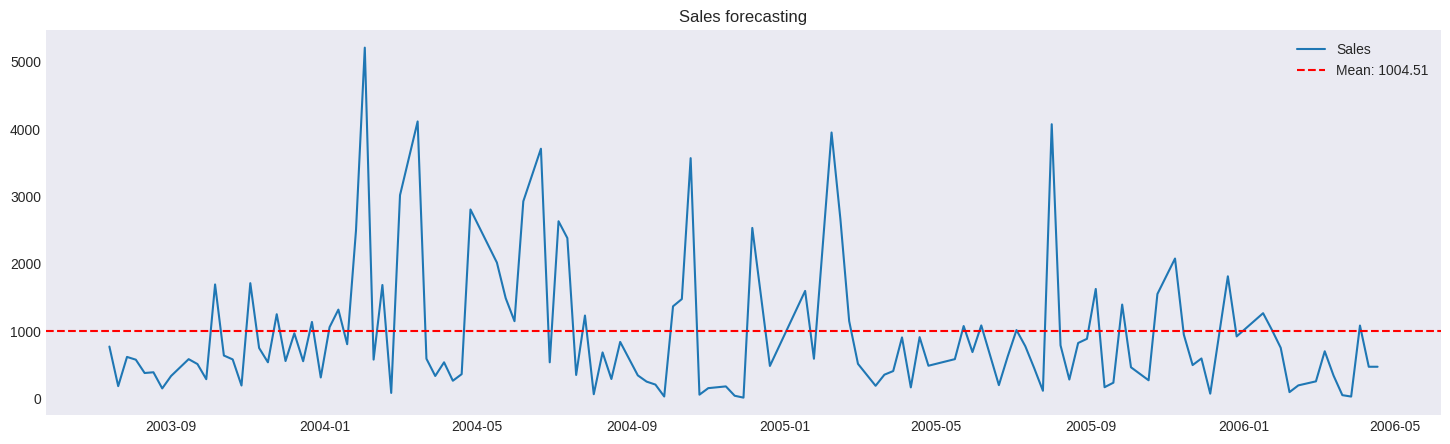

In [153]:
plt.figure(figsize=(18,5))
plt.plot(sales['QuantitySold'], linestyle="-", label = 'Sales')
plt.axhline(y=mean_value, color='r', linestyle="--", label=f"Mean: {mean_value:.2f}")
plt.title('Sales forecasting')
plt.legend()
plt.grid()
plt.show()

In [154]:
import seaborn as sns

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


<Axes: ylabel='QuantitySold'>

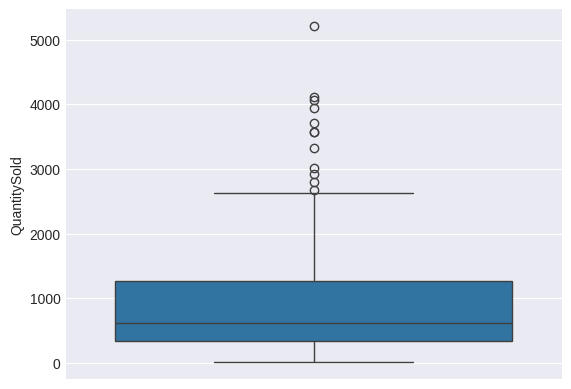

In [155]:
#estudio de valores atipicos
sns.boxplot(sales['QuantitySold'])

In [156]:
q1 = sales['QuantitySold'].quantile(0.25)
q3 = sales['QuantitySold'].quantile(0.75)

iqr = q3-q1

lim_inf = q1 - 1.5*iqr
lim_sup = q3 + 1.5*iqr

outliers = sales[(sales['QuantitySold'] < lim_inf) | (sales['QuantitySold'] > lim_sup)]

perc_out = (len(outliers) / len(sales['QuantitySold'])) * 100

print(f'Percentage outliers:  {perc_out}')

Percentage outliers:  8.275862068965518


In [157]:
sales['QuantitySold'].median(), sales['QuantitySold'].mean()

(620.0, 1004.5068965517241)

In [159]:
# sustituimos los valores atipicos por la mediana

sales['QuantitySold_no_out'] = np.where((sales['QuantitySold'] < lim_inf) | (sales['QuantitySold'] > lim_sup),
                              sales['QuantitySold'].median(), sales['QuantitySold'])

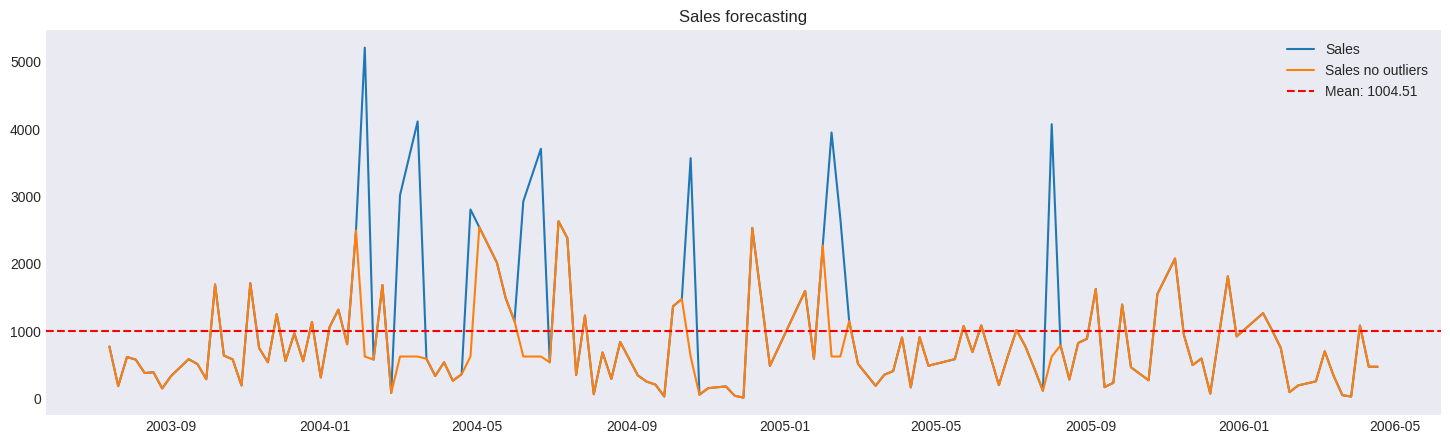

In [160]:
plt.figure(figsize=(18,5))
plt.plot(sales['QuantitySold'], linestyle="-", label = 'Sales')
plt.plot(sales['QuantitySold_no_out'], linestyle="-", label = 'Sales no outliers' )
plt.axhline(y=mean_value, color='r', linestyle="--", label=f"Mean: {mean_value:.2f}")
plt.title('Sales forecasting')
plt.legend()
plt.grid()
plt.show()

In [116]:
#sales['QuantitySold'] = sales['QuantitySold_no_out']
#sales.drop(columns=['QuantitySold_no_out'], inplace=True)

p-value Kolmogorov-Smirnov: 2.147655317497006e-86
p-value Shapiro-Wilk: 1.088254714552583e-12


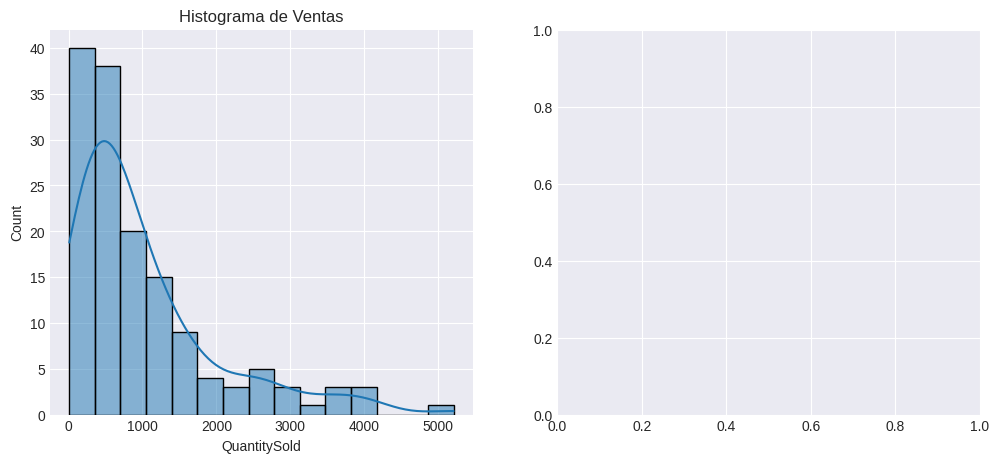

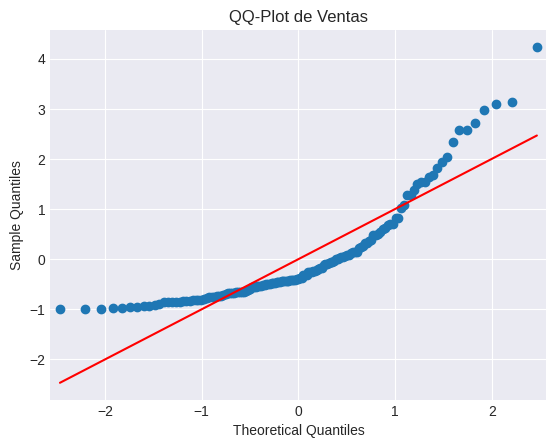

La serie NO es normal. Aplicando Box-Cox...
Lambda de Box-Cox: 0.21182109954163944


In [161]:
# comprobar la normalidad

from scipy.stats import shapiro, ks_2samp
from scipy.stats import norm
import statsmodels.api as sm

residuos = sales['QuantitySold']

# Test de Kolmogorov-Smirnov
ks_stat, p_ks = ks_2samp(residuos, norm.rvs(size=len(residuos)))
# Test de Shapiro-Wilk (para n < 5000)
shapiro_stat, p_shapiro = shapiro(residuos) if len(residuos) < 5000 else (None, None)

print(f"p-value Kolmogorov-Smirnov: {p_ks}")
print(f"p-value Shapiro-Wilk: {p_shapiro}")

# Histograma y QQ-Plot para ver distribución
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.histplot(residuos, kde=True)
plt.title("Histograma de Ventas")

plt.subplot(122)
sm.qqplot(residuos, line='s', fit=True)
plt.title("QQ-Plot de Ventas")
plt.show()

# Si p-valor < 0.05 en ambos test, la serie no es normal -> aplicar Box-Cox
if p_ks < 0.05 or (p_shapiro is not None and p_shapiro < 0.05):
    print("La serie NO es normal. Aplicando Box-Cox...")
    sales['QuantitySold'] = sales['QuantitySold'] + 1e-6
    sales['QuantitySold'], lambda_bc = boxcox(sales['QuantitySold'])
    print(f"Lambda de Box-Cox: {lambda_bc}")
else:
    print("La serie es normal. No es necesario aplicar Box-Cox.")

p-value Kolmogorov-Smirnov: 2.147655317497006e-86
p-value Shapiro-Wilk: 0.7285858794710836


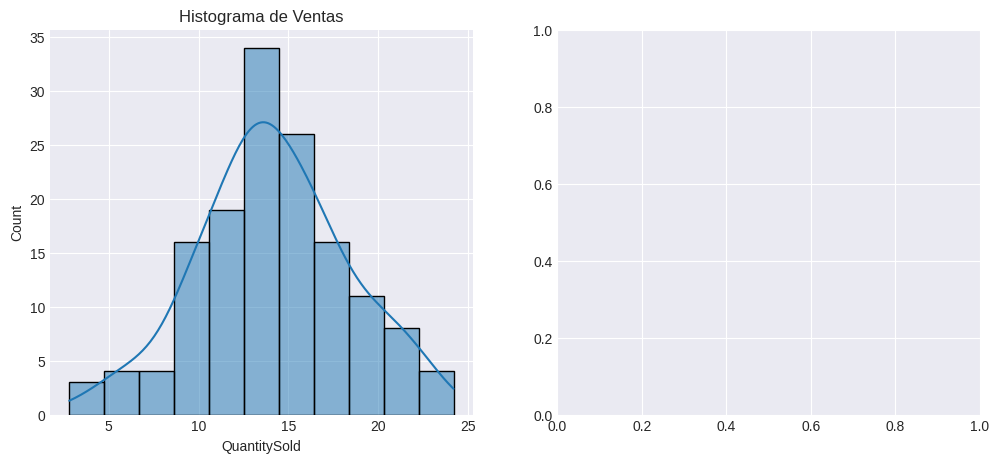

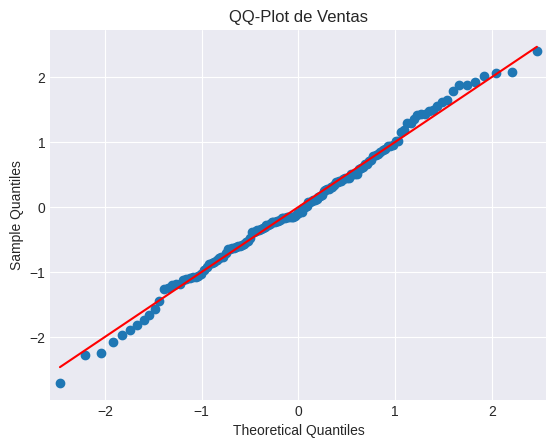

In [162]:
ks_stat, p_ks = ks_2samp(sales['QuantitySold'], norm.rvs(size=len(residuos)))
# Test de Shapiro-Wilk (para n < 5000)
shapiro_stat, p_shapiro = shapiro(sales['QuantitySold']) if len(sales['QuantitySold']) < 5000 else (None, None)

print(f"p-value Kolmogorov-Smirnov: {p_ks}")
print(f"p-value Shapiro-Wilk: {p_shapiro}")

# Histograma y QQ-Plot para ver distribución
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.histplot(sales['QuantitySold'], kde=True)
plt.title("Histograma de Ventas")

plt.subplot(122)
sm.qqplot(sales['QuantitySold'], line='s', fit=True)
plt.title("QQ-Plot de Ventas")
plt.show()

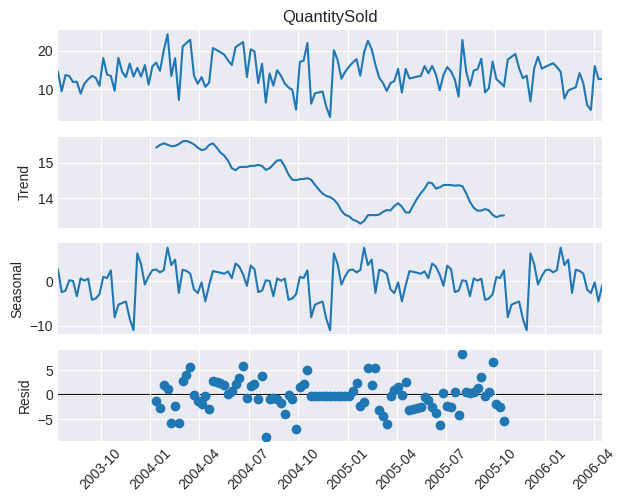

In [163]:
# descomposicion de la serie temporal

descomposicion = sm.tsa.seasonal_decompose(sales['QuantitySold'], model='additive')
descomposicion.plot()
plt.xticks(rotation = 45)
plt.show()

In [164]:
train = round(len(sales)*0.7)

train_data = sales[:int(train)]['QuantitySold']
test_data = sales[int(train):]['QuantitySold']
train_data.shape, test_data.shape

((102,), (43,))

In [165]:
train

102

In [166]:
train_data, test_data

(OrderDate
 2003-07-14    14.563659
 2003-07-21     9.461283
 2003-07-28    13.670811
 2003-08-04    13.403539
 2003-08-11    11.846838
                 ...    
 2005-05-23    15.979292
 2005-05-30    14.107897
 2005-06-06    16.015949
 2005-06-13    13.823873
 2005-06-20     9.703790
 Freq: W-MON, Name: QuantitySold, Length: 102, dtype: float64,
 OrderDate
 2005-06-27    13.708735
 2005-07-04    15.728515
 2005-07-11    14.590185
 2005-07-18    12.507293
 2005-07-25     8.080903
 2005-08-01    22.736740
 2005-08-08    14.658526
 2005-08-15    10.829058
 2005-08-22    14.838193
 2005-08-29    15.142153
 2005-09-05    17.878629
 2005-09-12     9.184370
 2005-09-19    10.230842
 2005-09-26    17.152617
 2005-10-03    12.579552
 2005-10-10    11.737891
 2005-10-17    10.696645
 2005-10-24    17.653413
 2005-10-31    18.410483
 2005-11-07    19.085205
 2005-11-14    15.429730
 2005-11-21    12.835318
 2005-11-28    13.522675
 2005-12-05     6.818743
 2005-12-12    15.407098
 2005-12-19    

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -8.586430304560244, p-value: 7.485650985904334e-14
KPSS Statistic: 0.21709007747571005, p-value: 0.1

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -7.82974661338283, p-value: 6.33963522076335e-12
KPSS Statistic: 0.11587572176872668, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -9.113073136455942, p-value: 3.3586051946806782e-15
KPSS Statistic: 0.11401534421691069, p-value: 0.1


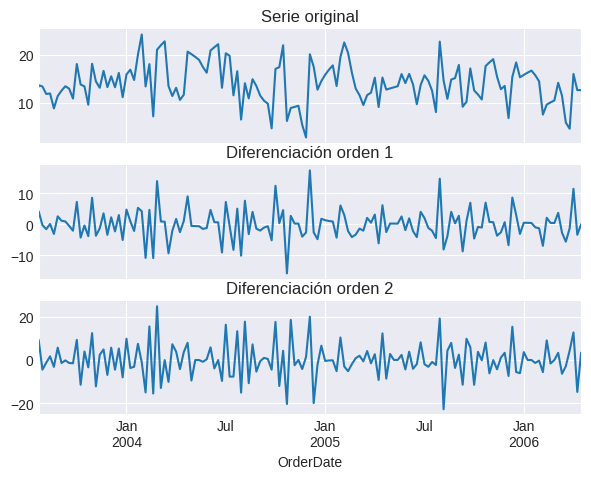

In [167]:
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

datos_diff_1 = sales['QuantitySold'].diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(sales['QuantitySold'])
kpss_result = kpss(sales['QuantitySold'])
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(sales['QuantitySold'].diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(sales['QuantitySold'].diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
sales['QuantitySold'].plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

d = 1

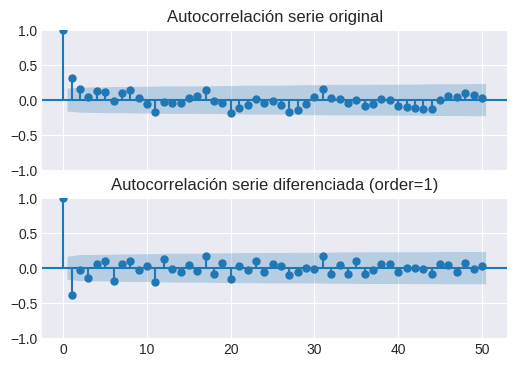

In [168]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(sales['QuantitySold'], ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

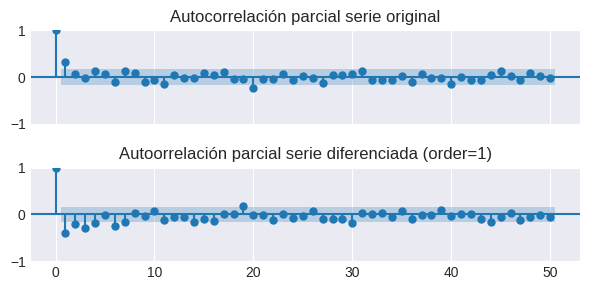

In [169]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)
plot_pacf(sales['QuantitySold'], ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout();

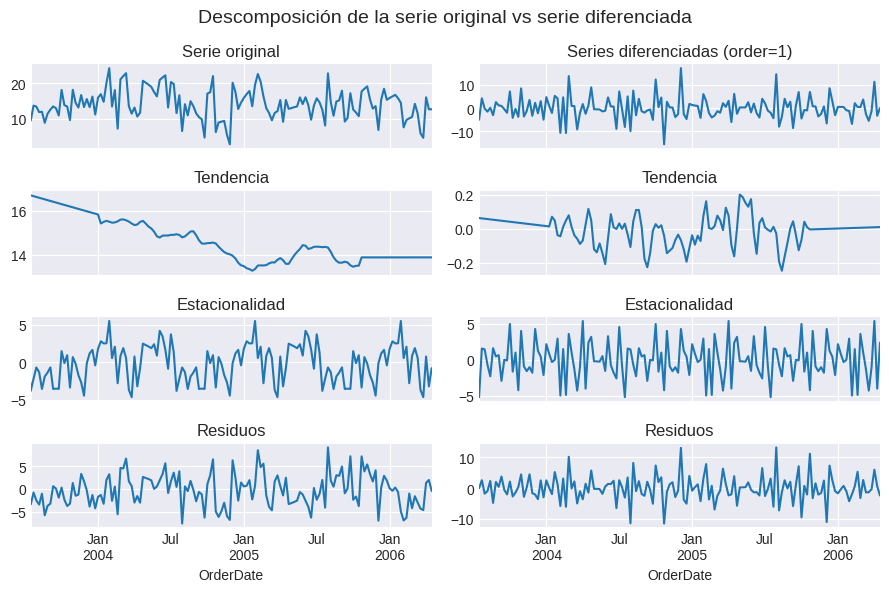

In [170]:
# Descomposición de la serie original y la serie diferenciada
# ==============================================================================
res_decompose = seasonal_decompose(sales['QuantitySold'], model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(datos_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos', fontsize=12)
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout();

se sugiere una estacionalidad anual.

In [171]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
datos_diff_1_12 = train_data.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(datos_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -3.997458311935128, p-value: 0.0014238789101590399
KPSS Statistic: 0.033967578120692794, p-value: 0.1


In [172]:
modelo_autoarima = auto_arima(train_data, seasonal=True, m=12, trace=True, suppress_warnings=True)

print(f"Mejor modelo sugerido por auto_arima: {modelo_autoarima.order}, {modelo_autoarima.seasonal_order}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=586.616, Time=1.00 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=592.109, Time=0.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=583.819, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=587.186, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=844.446, Time=0.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=581.830, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=583.817, Time=0.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=585.348, Time=0.67 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=582.021, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=582.511, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=585.308, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=583.032, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=620.175, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.750 seconds
Mejor modelo sugerido por auto_arima: (1, 0, 0), (0, 0, 0, 12)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [175]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = train_data, order = (2, 0, 1), seasonal_order = (1, 1, 1, 12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       QuantitySold   No. Observations:                  102
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -266.916
Date:                            Thu, 20 Feb 2025   AIC                            545.833
Time:                                    19:55:48   BIC                            560.832
Sample:                                07-14-2003   HQIC                           551.881
                                     - 06-20-2005                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1039      0.429     -0.242      0.809      -0.946       0.738
ar.L2          0.3282      0.155      2.119      0.034       0.025       0.632
ma.L1          0.4025      0.451      0.892      0.372      -0.481       1.286
ar.S.L12      -0.0346      0.174     -0.199      0.843      -0.376       0.307
ma.S.L12      -0.9991     60.631     -0.016      0.987    -119.833     117.835
sigma2        16.4218    993.266      0.017      0.987   -1930.345    1963.188
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.40
Prob(Q):                              0.99   Prob(JB):                         0.82
Heteroskedasticity (H):               1.04   Skew:                            -0.08
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [176]:
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=len(test_data)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(4))

,predicciones_statsmodels
2005-06-27,13.162857
2005-07-04,11.467529
2005-07-11,12.210380
2005-07-18,14.505879


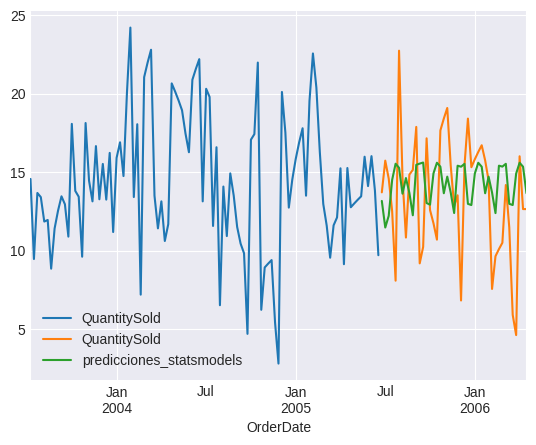

In [177]:
train_data.plot()
test_data.plot()
predicciones_statsmodels.plot()
plt.legend()
plt.show()


In [178]:
# Modelo SARIMAX con skforecast.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = Sarimax(order=(2, 0, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=train_data)
modelo.summary()
warnings.filterwarnings("default")

In [179]:
# Modelo SARIMAX con pdmarima.Sarimax
# ==============================================================================
modelo = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=train_data)
modelo.summary()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  102
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -267.985
Date:                            Thu, 20 Feb 2025   AIC                            547.970
Time:                                    19:56:02   BIC                            562.901
Sample:                                07-14-2003   HQIC                           553.988
                                     - 06-20-2005                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0217      0.030     -0.720      0.472      -0.081       0.037
ar.L1          0.2445      0.142      1.719      0.086      -0.034       0.523
ma.L1         -0.8929      0.072    -12.433      0.000      -1.034      -0.752
ar.S.L12      -0.0427      0.180     -0.238      0.812      -0.395       0.310
ma.S.L12      -0.9993     70.648     -0.014      0.989    -139.467     137.469
sigma2        17.6176   1242.426      0.014      0.989   -2417.492    2452.727
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 0.25
Prob(Q):                              0.64   Prob(JB):                         0.88
Heteroskedasticity (H):               1.07   Skew:                            -0.13
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [180]:
# Prediction
# ==============================================================================
predicciones_pdmarima = modelo.predict(len(test_data))
predicciones_pdmarima.name = 'predicciones_pdmarima'
display(predicciones_pdmarima.head(4))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,predicciones_pdmarima
2005-06-27,12.605139
2005-07-04,10.844372
2005-07-11,10.405376
2005-07-18,12.576411


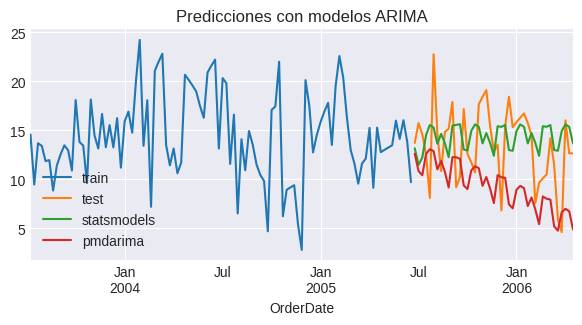

In [181]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
train_data.plot(ax=ax, label='train')
test_data.plot(ax=ax, label='test')
predicciones_statsmodels.plot(ax=ax, label='statsmodels')
#predicciones_skforecast.columns = ['skforecast']
#predicciones_skforecast.plot(ax=ax, label='skforecast')
predicciones_pdmarima.plot(ax=ax, label='pmdarima')
ax.set_title('Predicciones con modelos ARIMA')
ax.legend();

In [182]:
# Modelo ARIMA con ForecasterSarimax y skforecast Sarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
             )
forecaster.fit(y=train_data, suppress_warnings=True)

# Predicción
predicciones = forecaster.predict(steps=len(test_data))
predicciones.head(4)

,pred
2005-06-27,13.384044
2005-07-04,11.823975
2005-07-11,11.455290
2005-07-18,13.777255


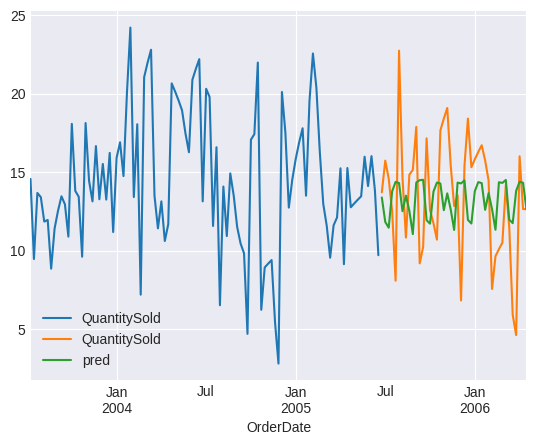

In [183]:
train_data.plot()
test_data.plot()
predicciones.plot()
plt.legend()
plt.show()


In [184]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                maxiter=200
                            )
             )
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(train_data),
        refit              = True,
        fixed_train_size   = False,
)
metrica, predicciones = backtesting_sarimax(
                            forecaster            = forecaster,
                            y                     = sales['QuantitySold'],
                            cv                    = cv,
                            metric                = 'mean_absolute_error',
                            n_jobs                = "auto",
                            suppress_warnings_fit = True,
                            verbose               = True,
                            show_progress         = True
                        )
display(metrica)
display(predicciones.head(4))

Information of folds
--------------------
Number of observations used for initial training: 102
Number of observations used for backtesting: 43
    Number of folds: 4
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 7 observations.

Fold: 0
    Training:   2003-07-14 00:00:00 -- 2005-06-20 00:00:00  (n=102)
    Validation: 2005-06-27 00:00:00 -- 2005-09-12 00:00:00  (n=12)
Fold: 1
    Training:   2003-07-14 00:00:00 -- 2005-09-12 00:00:00  (n=114)
    Validation: 2005-09-19 00:00:00 -- 2005-12-05 00:00:00  (n=12)
Fold: 2
    Training:   2003-07-14 00:00:00 -- 2005-12-05 00:00:00  (n=126)
    Validation: 2005-12-12 00:00:00 -- 2006-02-27 00:00:00  (n=12)
Fold: 3
    Training:   2003-07-14 00:00:00 -- 2006-02-27 00:00:00  (n=138)
    Validation: 2006-03-06 00:00:00 -- 2006-04-17 00:00:00  (n=7)



  0%|          | 0/4 [00:00<?, ?it/s]

,mean_absolute_error
0,3.324294


,pred
2005-06-27,13.384044
2005-07-04,11.823975
2005-07-11,11.455290
2005-07-18,13.777255


In [185]:
y = sales['QuantitySold']


In [186]:
train

102

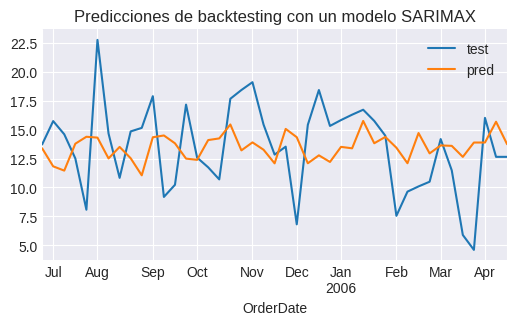

In [187]:
# prompt: me da este error: TypeError                                 Traceback (most recent call last)
# <ipython-input-97-d54808365062> in <cell line: 0>()
#       2 # ==============================================================================
#       3 fig, ax = plt.subplots(figsize=(6, 3))
# ----> 4 y.loc[train:].plot(ax=ax, label='test')
#       5 predicciones.plot(ax=ax)
#       6 ax.set_title('Predicciones de backtesting con un modelo SARIMAX')
# 9 frames
# /usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py in _raise_invalid_indexer(self, form, key, reraise)
#    4299         if reraise is not lib.no_default:
#    4300             raise TypeError(msg) from reraise
# -> 4301         raise TypeError(msg)
#    4302
#    4303     # --------------------------------------------------------------------
# TypeError: cannot do slice indexing on DatetimeIndex with these indexers [102] of type int, aqui fig, ax = plt.subplots(figsize=(6, 3))
# y.loc[train:].plot(ax=ax, label='test')
# predicciones.plot(ax=ax)
# ax.set_title('Predicciones de backtesting con un modelo SARIMAX')
# ax.legend();

import matplotlib.pyplot as plt
# The error occurs because you are trying to use an integer (102) to slice a DatetimeIndex.
# `y.loc[train:]` is incorrect because `train` is an integer representing the index where the test set begins.
# You should use the DatetimeIndex values to slice the DataFrame

fig, ax = plt.subplots(figsize=(6, 3))
y.loc[y.index[train]:].plot(ax=ax, label='test') # Correct slicing using the index
predicciones.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMAX')
ax.legend();


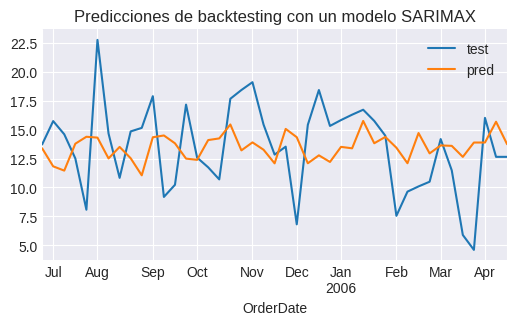

In [188]:
# Gráfico predicciones de backtesting
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
y.loc[y.index[train]:].plot(ax=ax, label='test') # Correct slicing using the index
predicciones.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMAX')
ax.legend();


In [189]:
sales

,QuantitySold,QuantitySold_no_out
OrderDate,,
2003-07-14,14.563659,768.0
2003-07-21,9.461283,180.0
2003-07-28,13.670811,614.0
2003-08-04,13.403539,573.0
2003-08-11,11.846838,375.0
...,...,...
2006-03-20,5.901810,46.0
2006-03-27,4.614672,25.0
2006-04-03,16.007824,1080.0


In [221]:
df = pd.merge(df_order_details, df_orders, on = 'OrderID')
df = pd.merge(df, df_products, on = 'ProductID')
df.head()

,OrderDetailID,OrderID,ProductID,QuantitySold,UnitSalesPrice,total_price,CustomerID,EmployeeID,ShippingMethodID,OrderDate,...,Category,Gender,ProductLine,Weight,Size,PackSize,Status,InventoryDate,PurchasePrice,ProductType
0,2,2,955,5,7.5,37.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,997,XXL,Dozen,In Production,2003-07-10,7.15,PCL29
1,3,2,958,5,8.5,42.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,1110,XXL,Dozen,In Production,2003-07-10,8.30,PCL31S
2,5,2,959,5,8.5,42.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,1055,XXL,Dozen,In Production,2003-07-10,7.20,PCL31T
3,6,4,72,50,3.0,150.0,2,2,1,2003-07-11,...,Briefs,Boys' Briefs,Underwear,233,S,Dozen,In Production,2003-07-10,2.50,ERK61
4,7,4,9,50,3.2,160.0,2,2,1,2003-07-11,...,Briefs,Boys' Briefs,Underwear,325,M,Dozen,In Production,2003-07-10,2.70,ERK61


In [222]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df.dtypes

,0
OrderDetailID,int64
OrderID,int64
ProductID,int64
QuantitySold,int64
UnitSalesPrice,float64
total_price,float64
CustomerID,int64
EmployeeID,int64
ShippingMethodID,int64
OrderDate,datetime64[ns]


In [223]:
sales_ph = df.groupby(['OrderDate'])['QuantitySold'].sum().reset_index()
sales_ph

,OrderDate,QuantitySold
0,2003-07-10,145
1,2003-07-11,330
2,2003-07-14,768
3,2003-07-15,835
4,2003-07-16,540
...,...,...
741,2006-04-13,2044
742,2006-04-14,92
743,2006-04-18,147
744,2006-04-19,4145


In [224]:
sales_ph = sales_ph.rename(columns={'OrderDate': 'ds', 'QuantitySold': 'y'})

# Asegurar frecuencia diaria
sales_ph = sales_ph.set_index('ds').asfreq('D').reset_index()

# Interpolación de valores faltantes
sales_ph['y'] = sales_ph['y'].interpolate()

df = sales_ph

In [225]:
q1 = df['y'].quantile(0.25)
q3 = df['y'].quantile(0.75)
iqr = q3 - q1  # Rango intercuartílico
limite_inf = q1 - 1.5 * iqr
limite_sup = q3 + 1.5 * iqr

outliers = df[(df['y'] < limite_inf) | (df['y'] > limite_sup)]
print(f"Se encontraron {len(outliers)} outliers.")

# Opcional: reemplazo de outliers con media o mediana
df['y'] = np.where((df['y'] < limite_inf) | (df['y'] > limite_sup),
                   df['y'].median(), df['y'])

Se encontraron 51 outliers.


Lambda de Box-Cox: 0.36171688384508016


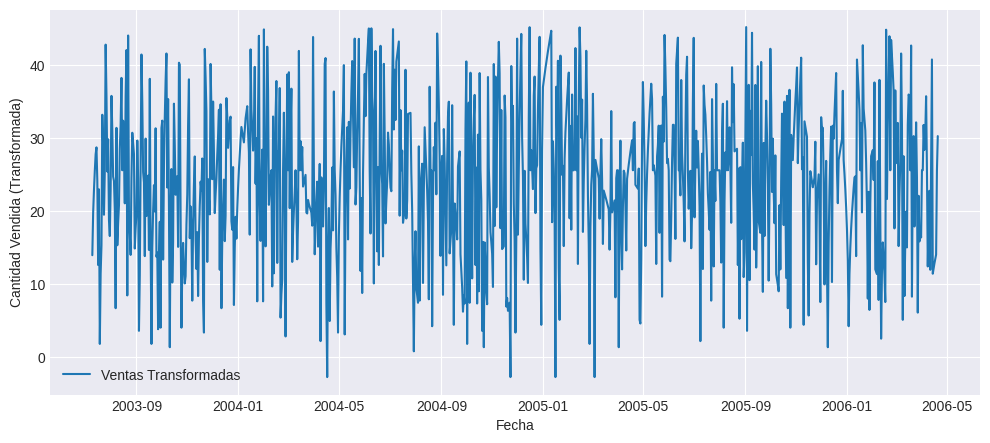

In [226]:
# --------------------------- TRANSFORMACIÓN BOX-COX ---------------------------
df['y'] = df['y'].apply(lambda x: x + 1e-6 if x <= 0 else x)
df['y'], lambda_bc = boxcox(df['y'])
print(f"Lambda de Box-Cox: {lambda_bc}")

# --------------------------- VISUALIZACIÓN DE LA SERIE ---------------------------
plt.figure(figsize=(12,5))
plt.plot(df['ds'], df['y'], label="Ventas Transformadas")
plt.xlabel("Fecha")
plt.ylabel("Cantidad Vendida (Transformada)")
plt.legend()
plt.show()



DEBUG:cmdstanpy:input tempfile: /tmp/tmpljmr7j7o/0t76_zhb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpljmr7j7o/dvj5tb9u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95394', 'data', 'file=/tmp/tmpljmr7j7o/0t76_zhb.json', 'init=/tmp/tmpljmr7j7o/dvj5tb9u.json', 'output', 'file=/tmp/tmpljmr7j7o/prophet_modeltgsttfps/prophet_model-20250220201754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:17:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:17:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


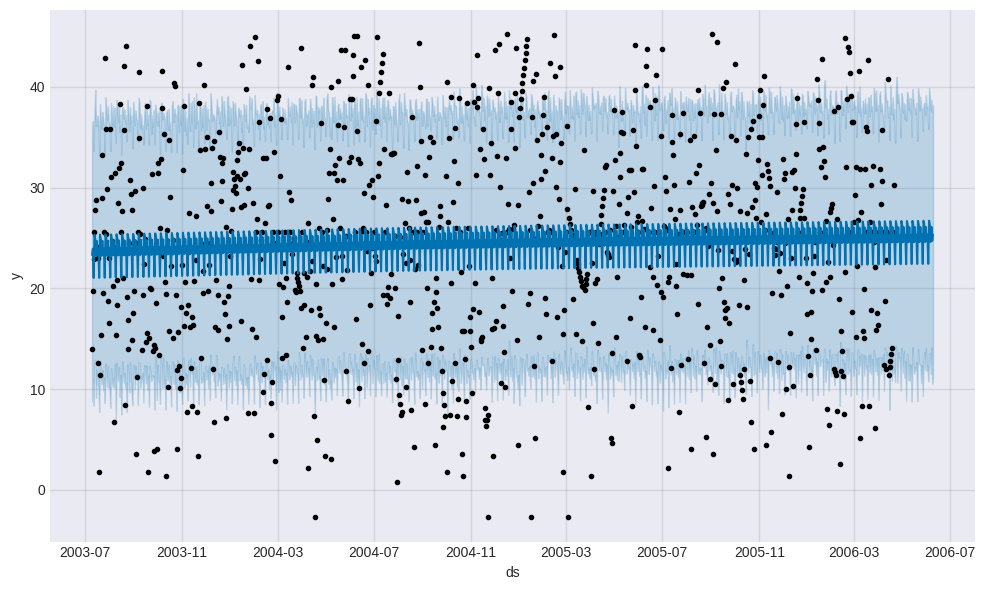

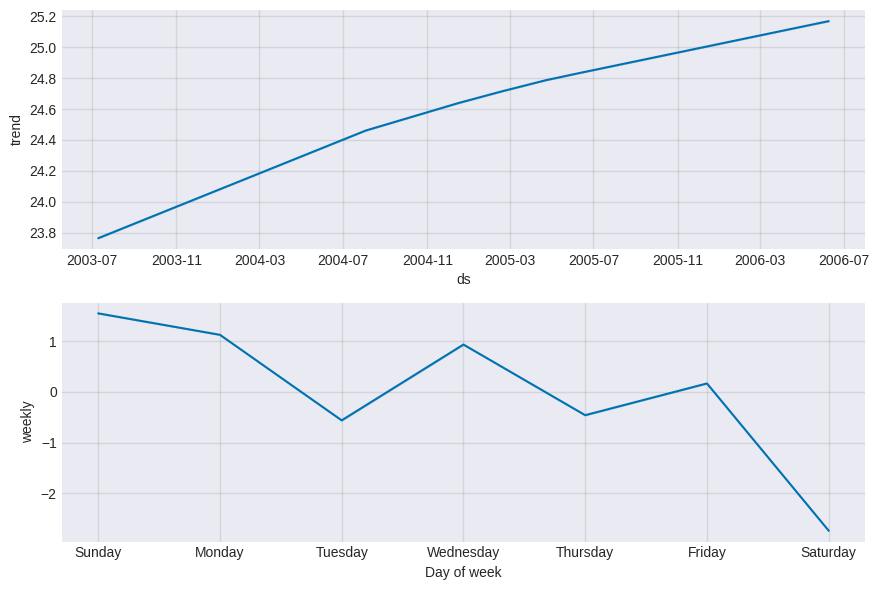

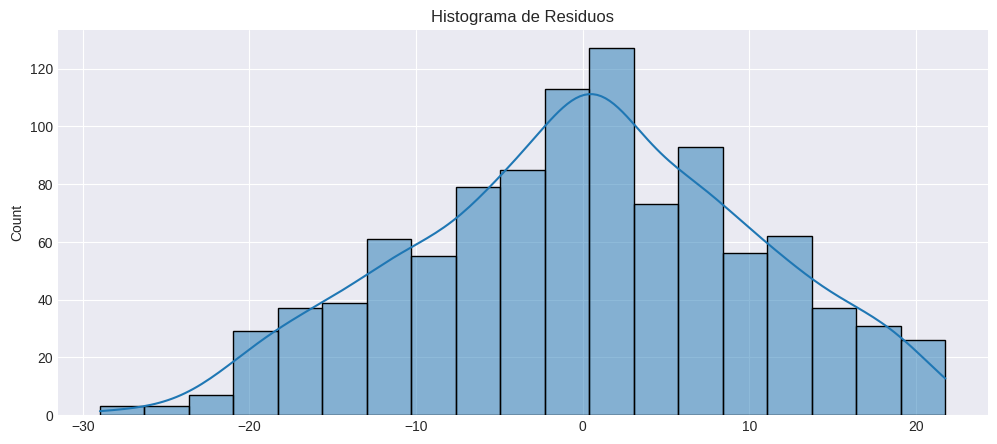

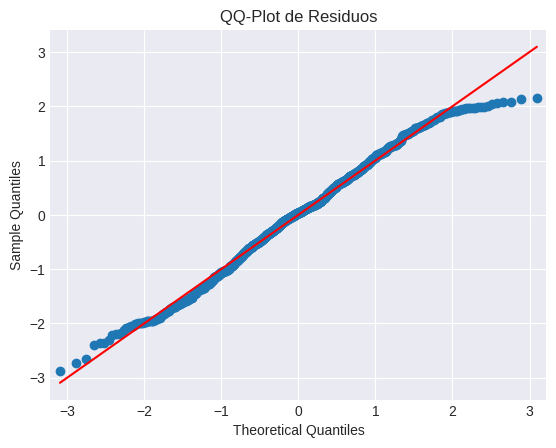

In [233]:
# --------------------------- CREACIÓN Y AJUSTE DEL MODELO CON PROPHET ---------------------------
modelo_prophet = Prophet(seasonality_mode='additive', yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
modelo_prophet.fit(df)

# --------------------------- PREDICCIONES ---------------------------
# Crear un DataFrame con las fechas futuras para las que queremos hacer las predicciones
future = modelo_prophet.make_future_dataframe(periods=50, freq = 'D')

# Realizar las predicciones
forecast = modelo_prophet.predict(future)

# Visualizar las predicciones
modelo_prophet.plot(forecast)
plt.show()

# --------------------------- COMPONENTES DEL MODELO ---------------------------
modelo_prophet.plot_components(forecast)
plt.show()

# --------------------------- EVALUACIÓN DEL MODELO ---------------------------
# Evaluar los residuos
residuos = df['y'] - forecast['yhat'][:len(df)]

# Histograma de residuos
plt.figure(figsize=(12, 5))
sns.histplot(residuos, kde=True)
plt.title("Histograma de Residuos")
plt.show()

# QQ-Plot de residuos
import statsmodels.api as sm
sm.qqplot(residuos, line='s', fit=True)
plt.title("QQ-Plot de Residuos")
plt.show()


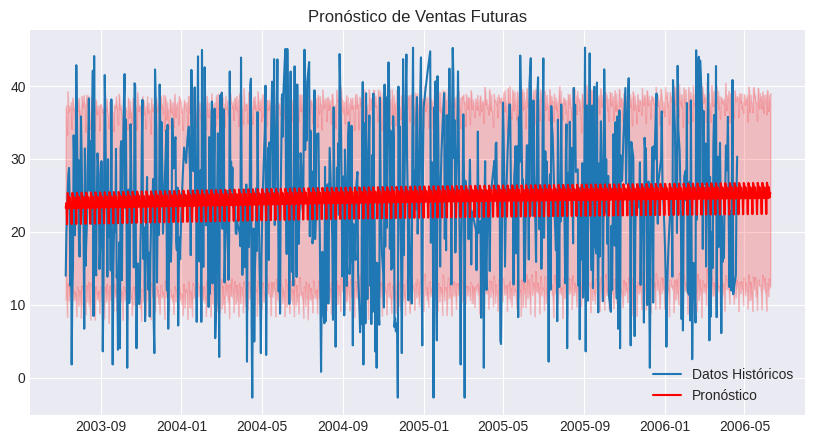

In [234]:
# Pronóstico para los siguientes 30 días
forecast_futuro = modelo_prophet.predict(future)
forecast_ci = forecast_futuro[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Visualización de las predicciones a futuro
plt.figure(figsize=(10,5))
plt.plot(df['ds'], df['y'], label="Datos Históricos")
plt.plot(forecast_futuro['ds'], forecast_futuro['yhat'], label="Pronóstico", color='red')
plt.fill_between(forecast_futuro['ds'], forecast_futuro['yhat_lower'], forecast_futuro['yhat_upper'], color='red', alpha=0.2)
plt.legend()
plt.title("Pronóstico de Ventas Futuras")
plt.show()


In [235]:
# Ajustar el modelo si es necesario
modelo_prophet = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,

)
modelo_prophet.fit(df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpljmr7j7o/r30ljbgw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpljmr7j7o/cgcmr18i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42287', 'data', 'file=/tmp/tmpljmr7j7o/r30ljbgw.json', 'init=/tmp/tmpljmr7j7o/cgcmr18i.json', 'output', 'file=/tmp/tmpljmr7j7o/prophet_modelis3nph2b/prophet_model-20250220201807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:18:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:18:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


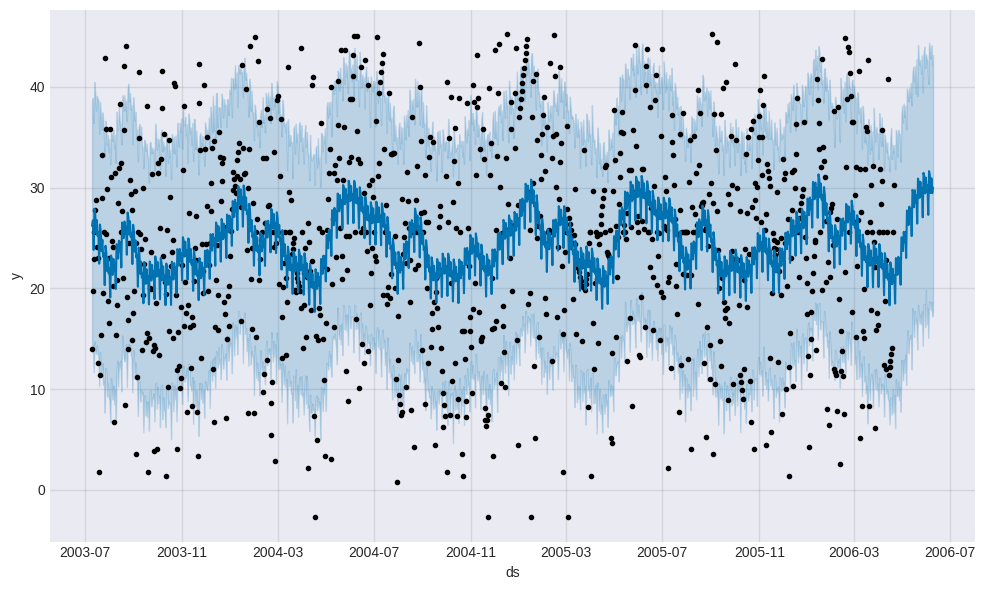

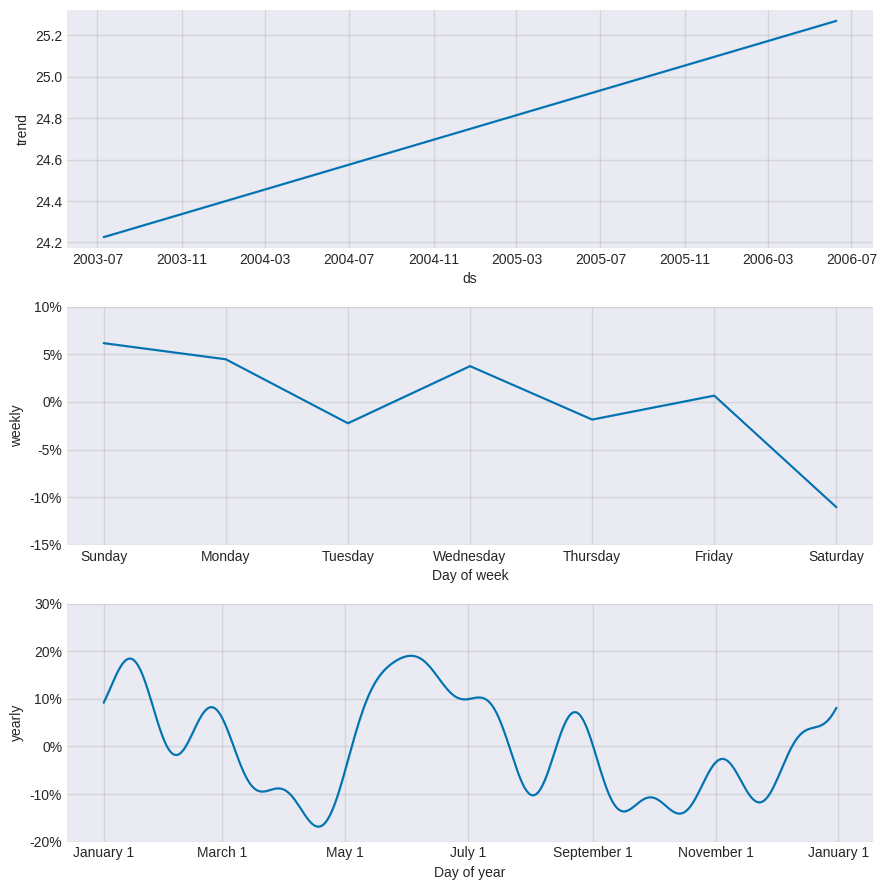

In [236]:
# Realizar las predicciones
forecast = modelo_prophet.predict(future)

# Visualizar las predicciones
modelo_prophet.plot(forecast)
plt.show()

# --------------------------- COMPONENTES DEL MODELO ---------------------------
modelo_prophet.plot_components(forecast)
plt.show()

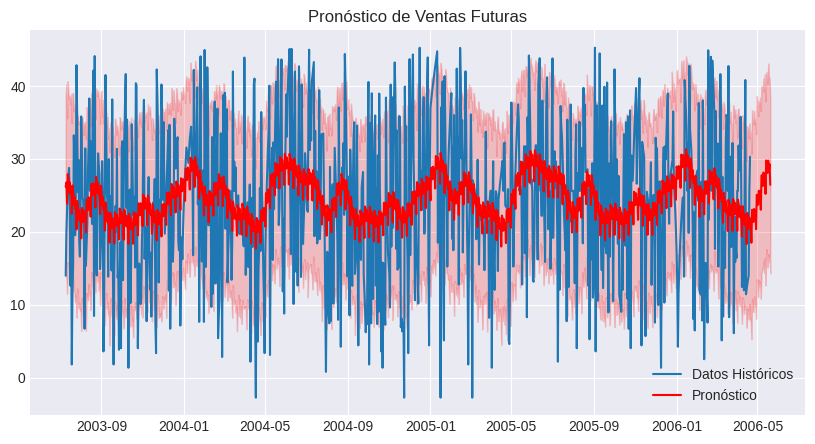

In [232]:
# Pronóstico para los siguientes 30 días
forecast_futuro = modelo_prophet.predict(future)
forecast_ci = forecast_futuro[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Visualización de las predicciones a futuro
plt.figure(figsize=(10,5))
plt.plot(df['ds'], df['y'], label="Datos Históricos")
plt.plot(forecast_futuro['ds'], forecast_futuro['yhat'], label="Pronóstico", color='red')
plt.fill_between(forecast_futuro['ds'], forecast_futuro['yhat_lower'], forecast_futuro['yhat_upper'], color='red', alpha=0.2)
plt.legend()
plt.title("Pronóstico de Ventas Futuras")
plt.show()